# Ex
### Exercise 12.1
- 9, 12, 13

### Exercise 12.2
- 2, 4

### Exercise 12.3
- 1, 3, 7, 10

# Com Ex
### Computer Exercise 12.1
- 1

### Computer Exercise 12.2
- 7

### Computer Exercise 12.3
- 2

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

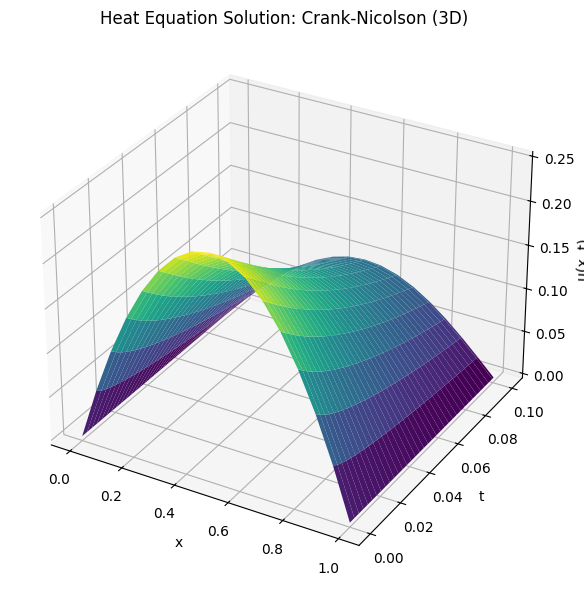

In [ ]:
def tridiag_solver_matrix(A, d):
    n = len(d)
    a = np.zeros(n-1)
    b = np.zeros(n)
    c = np.zeros(n-1)
    
    for i in range(n):
        b[i] = A[i, i]
        if i > 0:
            a[i-1] = A[i, i-1]
        if i < n-1:
            c[i] = A[i, i+1]
            
    cp = np.zeros(n-1)
    dp = np.zeros(n)
    cp[0] = c[0] / b[0]
    dp[0] = d[0] / b[0]
    
    for i in range(1, n-1):
        denom = b[i] - a[i-1] * cp[i-1]
        cp[i] = c[i] / denom
        dp[i] = (d[i] - a[i-1]*dp[i-1]) / denom
        
    dp[n-1] = (d[n-1] - a[n-2]*dp[n-2]) / (b[n-1] - a[n-2]*cp[n-2])
    x = np.zeros(n)
    x[-1] = dp[-1]
    
    for i in range(n-2, -1, -1):
        x[i] = dp[i] - cp[i] * x[i+1]
        
    return x

def crank_nicolson_1d(f_init, bc_left, bc_right, L=1.0, T=0.1, h=2**-4, k=2**-10, alpha=1.0):
    x = np.arange(0, L + h, h)
    N = len(x)
    t = np.arange(0, T + k, k)
    M = len(t)
    r = alpha * k / (2 * h ** 2)

    u = f_init(x)
    U = [u.copy()]
    times = [0.0]

    size = N - 2
    A = np.zeros((size, size))
    for i in range(size):
        A[i, i] = 1 + 2 * r
        if i > 0:
            A[i, i-1] = -r
        if i < size - 1:
            A[i, i+1] = -r

    B = np.zeros((size, size))
    for i in range(size):
        B[i, i] = 1 - 2 * r
        if i > 0:
            B[i, i-1] = r
        if i < size - 1:
            B[i, i+1] = r

    for m in range(1, M):
        tm = t[m]
        tm1 = t[m-1]
        lval = bc_left(tm)
        rval = bc_right(tm)
        lval1 = bc_left(tm1)
        rval1 = bc_right(tm1)

        u_inner = u[1:-1]
        b = B @ u_inner
        b[0]  += r * (lval + lval1)
        b[-1] += r * (rval + rval1)

        u_new = np.zeros_like(u)
        u_new[0] = lval
        u_new[-1] = rval
        u_new[1:-1] = tridiag_solver_matrix(A, b)
        u = u_new
        U.append(u.copy())
        times.append(tm)
        
    return x, times, U

def u0(x): return x * (1 - x)
def g0(t): return 0
def g1(t): return 0

h = 2 ** -4
k = 2 ** -10
L = 1.0
T = 0.1

x, times, U = crank_nicolson_1d(u0, g0, g1, L, T, h, k, 1.0)

X, T = np.meshgrid(x, times)
U = np.array(U)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, U, cmap='viridis', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x, t)')
ax.set_title('Heat Equation Solution: Crank-Nicolson (3D)')
plt.tight_layout()
plt.show()


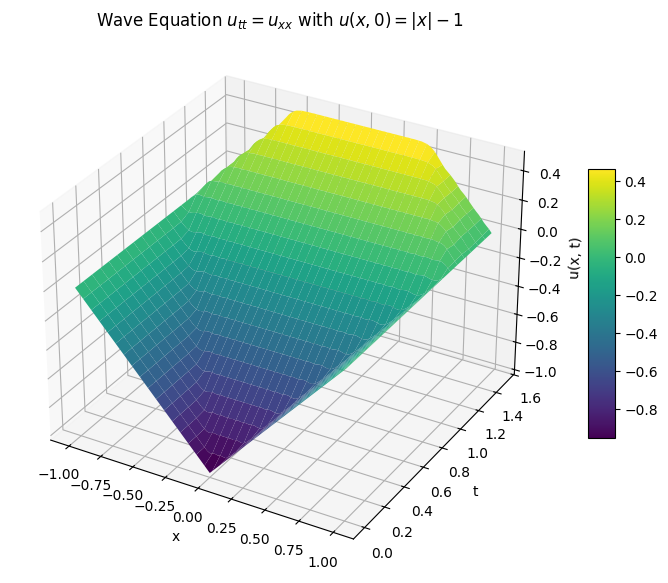

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def hyperbolic_solver(f, g, a, b, T, n=100, m=300, c=1.0, uL=0, uR=0, store_steps=100):
    h = (b - a) / n
    k = T / m
    x_grid = np.linspace(a, b, n+1)
    rho = (c * k / h) ** 2

    ts = np.arange(0, m+1, store_steps)
    if ts[-1] != m:
        ts = np.append(ts, m)

    sol_3d = np.zeros((len(ts), n+1))

    u = np.zeros(n+1)
    v = np.zeros(n+1)
    w = np.zeros(n+1)

    for i in range(n+1):
        x = a + i * h
        w[i] = f(x)
        v[i] = w[i] + k * g(x) + 0.5 * rho * (f(x+h) - 2*f(x) + f(x-h) if 0 < i < n else 0)
    v[0] = uL
    v[n] = uR

    t = 0
    sol_3d[t, :] = w.copy()
    t += 1
    if 1 in ts:
        sol_3d[t, :] = v.copy()
        t += 1

    for j in range(2, m+1):
        u_new = np.zeros(n+1)
        for i in range(1, n):
            u_new[i] = 2*v[i] - w[i] + rho * (v[i+1] - 2*v[i] + v[i-1])
        u_new[0] = uL
        u_new[n] = uR
        w, v = v, u_new
        if j in ts:
            sol_3d[t, :] = u_new.copy()
            t += 1

    t_grid = ts * (T / m)
    return x_grid, t_grid, sol_3d

f = lambda x: np.abs(x) - 1
g = lambda x: 0.0
a, b = -1, 1
T = 1.5
n = 100
m = 600
store_steps = 30

x_grid, t_grid, u_3d = hyperbolic_solver(
    f, g, a, b, T, n=n, m=m, store_steps=store_steps
)

X, T_grid = np.meshgrid(x_grid, t_grid)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, T_grid, u_3d, cmap='viridis', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x, t)')
ax.set_title(r'Wave Equation $u_{tt} = u_{xx}$ with $u(x,0)=|x|-1$')
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()


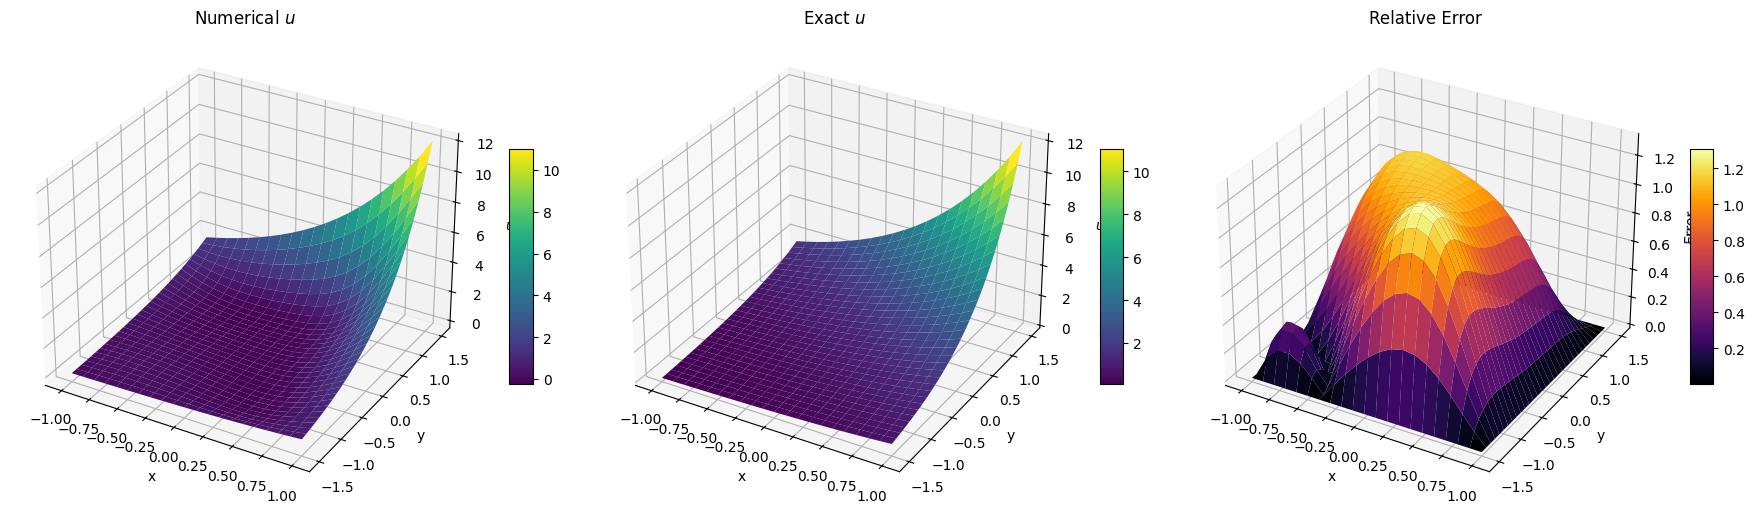

Numerical solution: u_num.min=-0.238408, u_num.max=12.182494
Exact solution:     U_exact.min=0.082085, U_exact.max=12.182494
Max relative error:      1.319436e+00


In [7]:
def poisson_gauss_seidel(f, g, u0_func, x_range, y_range, h, itmax):
    x = np.arange(x_range[0], x_range[1] + h, h)
    y = np.arange(y_range[0], y_range[1] + h, h)
    nx, ny = len(x), len(y)
    u = np.zeros((nx, ny))
    
    for i in range(nx):
        for j in range(ny):
            u[i, j] = u0_func(x[i], y[j])
            
    u[:, 0]    = g(x, y[0])
    u[:, -1]   = g(x, y[-1])
    u[0, :]    = g(x[0], y)
    u[-1, :]   = g(x[-1], y)
    
    for _ in range(itmax):
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                u[i, j] = 0.25 * (
                    u[i+1, j] + u[i-1, j] +
                    u[i, j+1] + u[i, j-1] -
                    h**2 * f(x[i], y[j])
                )
        u[:, 0]    = g(x, y[0])
        u[:, -1]   = g(x, y[-1])
        u[0, :]    = g(x[0], y)
        u[-1, :]   = g(x[-1], y)
    return x, y, u

f       = lambda x, y: 2 * np.exp(x + y)
g       = lambda x, y: np.exp(x + y)
u_exact = lambda x, y: np.exp(x + y)
u0      = lambda x, y: x*y
x_range, y_range = (-1, 1), (-1.5, 1.5)
h, itmax         = 0.1, 15

x, y, u_num = poisson_gauss_seidel(f, g, u0, x_range, y_range, h, itmax)
X, Y       = np.meshgrid(x, y, indexing='ij')
U_exact    = u_exact(X, Y)
error      = np.abs(u_num - U_exact) / np.abs(U_exact)

fig = plt.figure(figsize=(18, 5))

ax0 = fig.add_subplot(131, projection='3d')
surf0 = ax0.plot_surface(X, Y, u_num, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax0.set_title('Numerical $u$')
ax0.set_xlabel('x')
ax0.set_ylabel('y')
ax0.set_zlabel('$u$')
fig.colorbar(surf0, ax=ax0, shrink=0.5, aspect=10)

ax1 = fig.add_subplot(132, projection='3d')
surf1 = ax1.plot_surface(X, Y, U_exact, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax1.set_title('Exact $u$')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('$u$')
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)

ax2 = fig.add_subplot(133, projection='3d')
surf2 = ax2.plot_surface(X, Y, error, rstride=1, cstride=1, cmap='inferno', edgecolor='none')
ax2.set_title('Relative Error')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('Error')
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

plt.tight_layout()
plt.show()

print(f"Numerical solution: u_num.min={u_num.min():.6f}, u_num.max={u_num.max():.6f}")
print(f"Exact solution:     U_exact.min={U_exact.min():.6f}, U_exact.max={U_exact.max():.6f}")
print(f"Max relative error:      {error.max():.6e}")
